In [ ]:
# ! conda install -c conda-forge gdcm -y

In [1]:
import pandas as pd
import numpy as np
import re
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import albumentations as A
from tqdm.notebook import tqdm

from fastai.vision.all import *
from fastai.medical.imaging import *

In [2]:
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=80)

<Figure size 960x800 with 0 Axes>

<Figure size 960x800 with 0 Axes>

In [3]:
path = Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection')
path_resize = Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid_resize_512px')

In [4]:
path.ls()

(#9) [Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/DS-COCO_256'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/DS-COCO_256.zip'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/DS-COCO_512'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/DS-xhlulu_256'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/sample_submission.csv'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/test'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train_image_level.csv'),Path('/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train_study_level.csv')]

In [5]:
path_train_image = path/'train'
path_test_image = path/'test'
ss = pd.read_csv(path/'sample_submission.csv')
train_image = pd.read_csv(path/'train_image_level.csv')
train_study = pd.read_csv(path/'train_study_level.csv')

# Understanding train_study DF

In [6]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [7]:
#number of individual studies
len(train_study)

6054

In [8]:
#sanity check to make sure no repeats for individual studies
assert len(train_study) == train_study.id.nunique()

In [9]:
class_dist = train_study.iloc[:,1:].sum(axis=0); class_dist/sum(class_dist)

Negative for Pneumonia      0.276842
Typical Appearance          0.471589
Indeterminate Appearance    0.173274
Atypical Appearance         0.078295
dtype: float64

Number of classes = 4

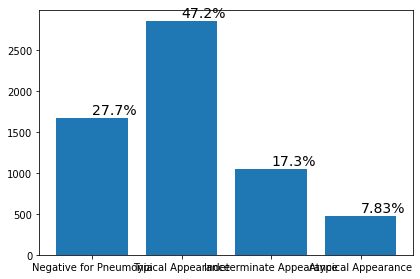

In [10]:
plt.bar(class_dist.index, class_dist.values)

for x, y in zip(class_dist.index, class_dist.values):
    plt.text(x, y+50, f'{y/len(train_study)*100:.3}%', fontsize=14)

plt.tight_layout()
plt.show()

In [11]:
# are there studies with more than one label? No
(train_study.iloc[:, 1:].sum(1) > 1).sum()

0

# Understanding train_image DF

In [12]:
train_image.head(5)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


In [13]:
# there are more images than study. This is because one study can have more than one image.
len(train_image)

6334

In [14]:
# checks if the number of studies in the image level is same as the train_study. Yes, it is
assert train_image.StudyInstanceUID.nunique() == len(train_study)

In [15]:
numimagesperstudy = train_image.groupby('StudyInstanceUID').count()['id'].sort_values(ascending=False)

In [16]:
numimagesperstudycounts = numimagesperstudy.value_counts(); numimagesperstudycounts

1    5822
2     207
3      15
4       4
5       3
9       1
6       1
7       1
Name: id, dtype: int64

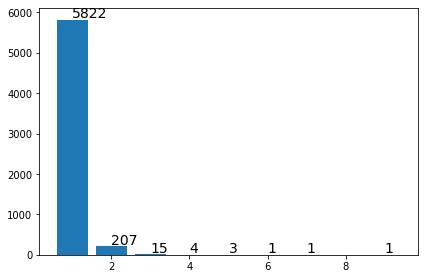

In [17]:
x = plt.bar(numimagesperstudycounts.index, numimagesperstudycounts.values)

for x, y in zip(numimagesperstudycounts.index, numimagesperstudycounts.values):
    plt.text(x, y+50, f'{y}', fontsize=14)

plt.tight_layout()
plt.show()

Most studies have only one image. About 230 studies have more than one image. There is one study with 9 images. Lets take a look at this.

In [18]:
numimagesperstudy[numimagesperstudy >8].index[0]

'0fd2db233deb'

In [19]:
train_image[train_image['StudyInstanceUID'] == numimagesperstudy[numimagesperstudy >8].index[0]]

,id,boxes,label,StudyInstanceUID
130,04cc2f7f4c4b_image,NaN,none 1 0 0 1 1,0fd2db233deb
156,05c063f5cef5_image,NaN,none 1 0 0 1 1,0fd2db233deb
551,156cb1f5c689_image,NaN,none 1 0 0 1 1,0fd2db233deb
964,26f643772090_image,"[{'x': 561.30269, 'y': 163.28797, 'width': 883.72108, 'height': 1331.81839}]",opacity 1 561.30269 163.28797 1445.02377 1495.10636,0fd2db233deb
1861,4c414b793562_image,NaN,none 1 0 0 1 1,0fd2db233deb
4044,a5a364383f34_image,NaN,none 1 0 0 1 1,0fd2db233deb
4340,b121806162c3_image,NaN,none 1 0 0 1 1,0fd2db233deb
4698,bee62c601ae9_image,NaN,none 1 0 0 1 1,0fd2db233deb
4902,c6e92e59a0ae_image,NaN,none 1 0 0 1 1,0fd2db233deb


This is interesting. Out of the 9 images, only one has a bbox. Other images have label none. Let's take a look at the study level label for this.

In [20]:
train_study[train_study['id'] == '0fd2db233deb_study']

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
361,0fd2db233deb_study,0,0,1,0


At study level, the label is 'Intermediate Appearace'.

Now, lets take a look at the distribution of number of bboxes per image.

In [21]:
train_image['n_boxes'] = train_image['boxes'].apply(lambda x: sum(1 for _ in re.findall('width', str(x))))

In [22]:
n_boxes = train_image['n_boxes'].value_counts(); n_boxes/sum(n_boxes)*100

2    49.147458
0    32.207136
1    15.361541
3     2.889170
4     0.363120
8     0.015788
5     0.015788
Name: n_boxes, dtype: float64

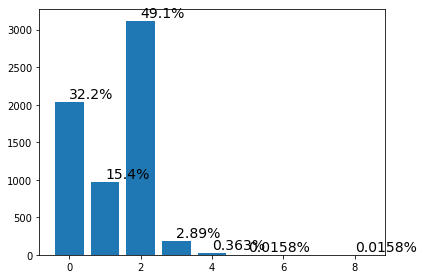

In [23]:
x = plt.bar(n_boxes.index, n_boxes.values)

for x, y in zip(n_boxes.index, n_boxes.values):
    plt.text(x, y+50, f'{y/len(train_image)*100:.3}%', fontsize=14)

plt.tight_layout()
plt.show()

Most images have <= 2 bboxes. 

In [24]:
train_image['label_only'] = train_image['label'].apply(lambda x: x.split()[0])

In [25]:
labels = train_image['label_only'].value_counts()

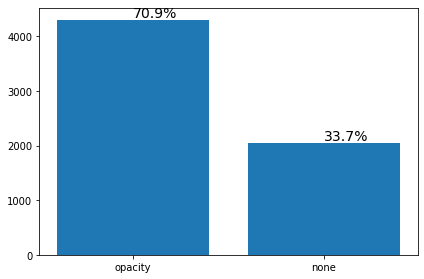

In [26]:
x = plt.bar(labels.index, labels.values)

for x, y in zip(labels.index, labels.values):
    plt.text(x, y+50, f'{y/len(train_study)*100:.3}%', fontsize=14)

plt.tight_layout()
plt.show()

70.9% of the images have label opacity.

In [27]:
train_study.columns = ['StudyInstanceUID', 'Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance']

In [28]:
train_image['StudyInstanceUID'] = train_image['StudyInstanceUID'].apply(lambda x: f'{x}_study')

Let's merge the dataframes. 

In [29]:
df = train_image.merge(train_study, on='StudyInstanceUID')

In [38]:
df.to_csv(path_resize / 'COVID_train_df.csv')
df.head()

,id,boxes,label,StudyInstanceUID,n_boxes,label_only,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75_study,2,opacity,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed_study,0,none,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7_study,2,opacity,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2_study,1,opacity,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e_study,2,opacity,0,1,0,0


# DICOM Metadata

The train images are stored in this format
```
--root [../input/siim-covid19-detection/train]
    |--StudyID01
        |--ImageID01
        |--ImageID02
    |--StudyID02
        |--ImageID01
        |--ImageID02
```

In [31]:
dcm_fns = get_dicom_files(path_train_image)

In [33]:
samp = dcm_fns[0].dcmread()

In [34]:
samp

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.59189821846420219299438915042640676800
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 65761e66de9f
(0008, 0020) Study Date                          DA: '4545ba78b753'
(0008, 0030) Study Time                          TM: 'bf1677526b2b'
(0008, 0050) Accession Number                    SH: '5f20f119e3df'
(0008, 0060) Modality                            CS: 'DX'
(0009, 0010) Private Creator                     LO: 'GEIIS'
(0010

MONOCHROME1
Pixel data represent a single monochrome image plane. The minimum sample value is intended to be displayed as white after any VOI gray scale transformations have been performed. 

MONOCHROME2
Pixel data represent a single monochrome image plane. The minimum sample value is intended to be displayed as black after any VOI gray scale transformations have been performed.

Let's create dicom metadata df. This takes a while hence I generated and uploaded the csv.

In [ ]:
# #to generate dicom metadata for train images
# df_dcm = pd.DataFrame.from_dicoms(dcm_fns, px_summ=True)
# df_dcm.to_csv('COVID_dcm_metadata.csv')

In [ ]:
# #to generate dicom metadata for test images
# dcm_test_fns = get_dicom_files(path_test_image)
# df_dcm_test = pd.DataFrame.from_dicoms(dcm_test_fns, px_summ=True)
# df_dcm_test.to_csv('COVID_dcm_metadata_test.csv')

In [35]:
df_dcm = pd.read_csv(path_resize / 'COVID_dcm_metadata.csv')
df_dcm_test = pd.read_csv(path_resize / 'COVID_dcm_metadata_test.csv')

In [36]:
df_dcm.columns

Index(['Unnamed: 0', 'SpecificCharacterSet', 'ImageType', 'SOPClassUID',
       'SOPInstanceUID', 'StudyDate', 'StudyTime', 'AccessionNumber',
       'Modality', 'Unnamed: 9', 'PatientName', 'PatientID', 'PatientSex',
       'DeidentificationMethod', 'DeidentificationMethodCodeSequence',
       'BodyPartExamined', 'ImagerPixelSpacing', 'StudyInstanceUID',
       'SeriesInstanceUID', 'StudyID', 'SeriesNumber', 'InstanceNumber',
       'SamplesPerPixel', 'PhotometricInterpretation', 'Rows', 'Columns',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'fname', 'MultiImageType', 'ImageType1', 'ImageType2',
       'MultiDeidentificationMethodCodeSequence',
       'DeidentificationMethodCodeSequence1',
       'DeidentificationMethodCodeSequence2',
       'DeidentificationMethodCodeSequence3',
       'DeidentificationMethodCodeSequence4',
       'DeidentificationMethodCodeSequence5', 'MultiImagerPixelSpacing',
       'ImagerPixelSpacing1', 'img_min', 'img_max', 'i

In [39]:
# Let's look at the modality
print(f"{df_dcm['Modality'].value_counts()}\n\n{df_dcm_test['Modality'].value_counts()}")

DX    3242
CR    3092
Name: Modality, dtype: int64

DX    661
CR    602
Name: Modality, dtype: int64


In [40]:
print(f"{df_dcm['PatientSex'].value_counts()}\n\n{df_dcm_test['PatientSex'].value_counts()}")

M    3564
F    2770
Name: PatientSex, dtype: int64

M    745
F    518
Name: PatientSex, dtype: int64


In [41]:
print(f"{df_dcm['PhotometricInterpretation'].value_counts()}\n\n{df_dcm_test['PhotometricInterpretation'].value_counts()}")

MONOCHROME2    4633
MONOCHROME1    1701
Name: PhotometricInterpretation, dtype: int64

MONOCHROME2    977
MONOCHROME1    286
Name: PhotometricInterpretation, dtype: int64


We have to consider this when we are preparing the dataset.

In [42]:
print(f"{df_dcm['PixelRepresentation'].value_counts()}\n\n{df_dcm_test['PixelRepresentation'].value_counts()}")

0    6334
Name: PixelRepresentation, dtype: int64

0    1263
Name: PixelRepresentation, dtype: int64


All dicom are `unsigned`. 

In [43]:
df_dcm['BitsAllocated'].value_counts()

16    5933
8      401
Name: BitsAllocated, dtype: int64

Some are 16bits while others are 8bits

In [44]:
#the following codes are from https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.grid(False)
    plt.axis('off')
    plt.show()


def plot_imgs(imgs, cols=3, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500), label=[]):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(label[i])
        plt.grid(False)
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

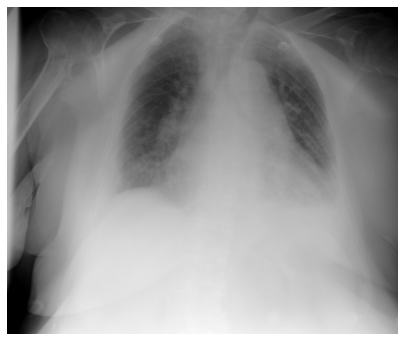

In [45]:
plot_img(dicom2array(dcm_fns[0]))

Let's take a look at the 9 images from study - `0fd2db233deb`

In [46]:
imgs_path = get_dicom_files(path_train_image/'0fd2db233deb')
imgs_id = [f"{str(img).split('/')[-1].split('.dcm')[0]}_image" for img in imgs_path]
imgs_label = list(df[df['id'].isin(imgs_id)]['label'].apply(lambda x: x.split()[0]).values)

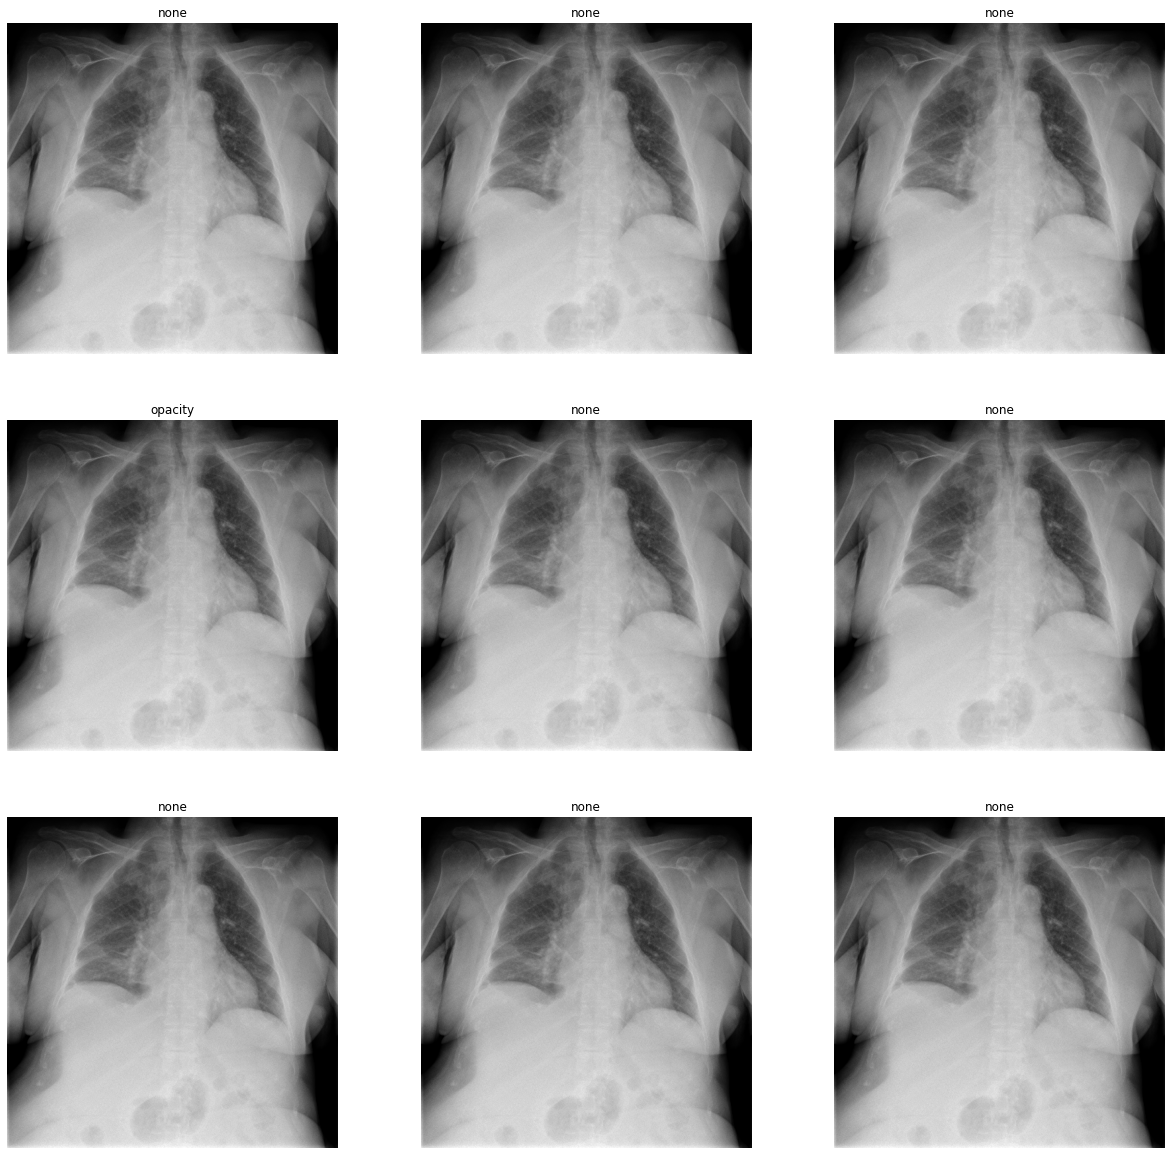

In [47]:
plot_imgs([dicom2array(img) for img in imgs_path], label=imgs_label)

They all look same to me :(

# Resize and create Smaller images for prototyping

The following codes are from this wonderful [notebook](https://www.kaggle.com/konradb/diy-rescaled-images-with-bboxes/output).

In [48]:
df.head(2)

,id,boxes,label,StudyInstanceUID,n_boxes,label_only,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75_study,2,opacity,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed_study,0,none,1,0,0,0


In [57]:
path_list = []
image_list = []
splits = []

for split in ['train']:   
    for dirname, _, filenames in tqdm(os.walk(str(path) + f'/{split}')):
        for file in filenames:
            fullpath = dirname + '/' + file
            path_list.append(fullpath)
            image_list.append(file)
            
temp_df = pd.DataFrame(image_list, columns =['image_id'])
temp_df['image_path'] = path_list

0it [00:00, ?it/s]

In [58]:
# for split in ['train']:  
#     print(str(path_resize) + f'/{split}')

temp_df.head()

,image_id,image_path
0,65761e66de9f.dcm,/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm
1,51759b5579bc.dcm,/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train/000c9c05fd14/e555410bd2cd/51759b5579bc.dcm
2,f6293b1c49e2.dcm,/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train/00292f8c37bd/73120b4a13cb/f6293b1c49e2.dcm
3,3019399c31f4.dcm,/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train/005057b3f880/e34afce999c5/3019399c31f4.dcm
4,bb4b1da810f3.dcm,/host_Data/Datasets/Kaggle-SIIM-Covid19/siim-covid19-detection/train/0051d9b12e72/152f6ec68d86/bb4b1da810f3.dcm


In [59]:
size=512
# size=1024
transform = A.Compose(
    [
        A.Resize(height = size , width = size, p=1),
    ], 
    p=1.0,  bbox_params=A.BboxParams( format='pascal_voc', min_area=0,  min_visibility=0, label_fields=['labels']  ))        

In [60]:
df['image_id']  = df['id'].apply(lambda s: s.replace('_image','') + '.dcm')
df = pd.merge(left = df, right = temp_df, on = 'image_id')

In [72]:
image_output = str(path_resize) + '/train'
!mkdir $image_output

OUTPUT_DIRECTORY = Path(image_output)

In [73]:
img_list = []
label_list = []

# loop over files
for ii in tqdm(range(len(df)), total=len(df)):
    # get the image
    row = df.loc[ii]
    img_path = row['image_path']
    img = dicom2array(path=img_path)
    newname = img_path.split('/')[-1].replace('dcm', 'jpg')
    img_list.append(newname)
    
    # get the bounding boxes
    bboxes = []
    bbox = []
    labels = []
    confidences = []

    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) :
            labels.append(l)
        if (i % 6 == 1):
            confidences.append(l)
        if (i % 6 > 1):
            bbox.append(np.clip(float(l), a_min = 0, a_max = None ))
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    

    # transform both
    result = transform(image = img, bboxes = bboxes, labels = np.ones(len(bboxes)))
    new_image = result['image']
    new_bboxes = np.array(result['bboxes']).tolist()

    # format the output
    # print('orig label: ' + row['label'])
    newlabel = ''
    if labels[0] == 'none':
        newlabel = 'none 1 0 0 1 1'
    else:
        for j in range(len(labels)):
            newlabel += labels[j] + ' ' + confidences[j] + ' ' +  ' '.join([str(np.round(f,5)) for f in new_bboxes[j]]) + ' '
    #print('new label:' + newlabel)
    label_list.append(newlabel)
    
    # store the new image
    cv2.imwrite(str(OUTPUT_DIRECTORY/newname), new_image)

  0%|          | 0/6334 [00:00<?, ?it/s]

/workspace/.virtualenvs/siim-covid19/lib/python3.8/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


In [76]:
# store the new boxes with image_ids
xmeta = pd.DataFrame(img_list, columns =['image_id'])
xmeta['label'] = label_list
xmeta.to_csv(path_resize / 'bounding_boxes512.csv', index = False)

In [ ]:
# # wrap it up
# !zip -rm -qq rescaled_with_bb512.zip train512 bounding_boxes_512.csv